# Training Your First Neural Net

In this exercise we're going to train a neural net using Pytorch.

I've already put together a cell to do the necessary imports and fetch the training and test data.

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 46915227.07it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1618617.22it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12804100.11it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7517967.15it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# 1. Setup Dataloaders

Pytorch has a special object called a `DataLoader` which we can use to iterate through batches of `X` and `y` training and test batches.

In neural nets, you need to choose a batch size. You calculate the loss for one batch before doing the backpropagation for that batch.

```python
batch_size = ...

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
```

You pick your own batch size here, but I recommend something more than 10 and less than 200.


In [4]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


## 2. Define Your Model

In Pytorch, we define a class to make a model. This should be largely copy-paste because the first layer _must_ be 784 (28x28) and the last layer must be 10 (10 digits), but feel free to change the hidden layer's size.

```python
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
```


In [5]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



## 3. Intialize Your Model, Loss Function, and Optimizer

Your model needs to be initialized. Do that. Print it to inspect it.

```python
model = NeuralNetwork().to("cpu")
print(model)
```

You'll also need to initialize objects for your loss function (which says how badly a batch performed) and your optimizer (which moves the weights based on the loss).

```python
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
```

In [6]:
model = NeuralNetwork().to("cpu")
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)



NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 4. Train Your Model

### 4a. Scaffolding for Epochs

One epoch is when you train your entire training dataset and then score your test dataset. You're going to do multiple epochs. Your pick as to how many (but I recommend less than 10 because it can take a while).

Make sure you initialize your model before we begin.

This is the rough scaffolding for the for-loop. We'll fill in the Train and Test sections in the next steps.

```python
num_epochs = ...
for epoch in range(num_epochs):
    # Train model for epoch
    ...
    # Test model for epoch
    ...

print("Model is done!")
```

### 4b. Train the Epoch

Here's some code for training our model for one epoch. Read through it and try and make sense of it. You should be doing this exactly once per epoch _inside_ the for-loop defined in step 3.

```python
# Train the model (loop over batches of training examples)
model.train()
num_training_samples = len(train_dataloader)
for i, (X, y) in enumerate(train_dataloader):
    X = X.to("cpu")
    y = y.to("cpu")

    # Compute prediction error for the batch
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Log our progress every 100 batches
    if i % 100 == 0:
        print(f"loss: {loss.item():>7f}  [{(i+1)*len(X):>5d}/{num_training_samples:>5d}]")
```

### 4c. Test the Epoch

Again, we test every epoch. Here's the code.

```python
# Test the epoch (loop over batches of testing examples)
model.eval()
num_test_samples = len(test_dataloader)
total_loss = 0
num_correct = 0
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to("cpu")
        y = y.to("cpu")
        pred = model(X)
        total_loss += loss_fn(pred, y).item()
        num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

# Evaluate
avg_loss = total_loss / num_test_samples
accuracy = num_correct / num_test_samples
print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>7f}")
```

### 4d. Train Your Model

Train your Neural Network and track the accuracy and the loss function.

In [11]:
num_epochs = 8
for epoch in range(num_epochs):
    # Train model for epoch
    model.train()
    num_training_samples = len(train_dataloader) * batch_size
    for i, (X, y) in enumerate(train_dataloader):
        X = X.to("cpu")
        y = y.to("cpu")

        # Compute prediction error for the batch
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Log our progress every 100 batches
        if i % 100 == 0:
            print(f"loss: {loss.item():>7f}  [{(i+1)*len(X):>5d}/{num_training_samples:>5d}]")

    # Test the epoch (loop over batches of testing examples)
    model.eval()
    num_test_samples = len(test_dataloader) * batch_size
    total_loss = 0
    num_correct = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to("cpu")
            y = y.to("cpu")
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Evaluate
    avg_loss = total_loss / num_test_samples
    accuracy = num_correct / num_test_samples
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>7f}")


print("Model is done!")





















loss: 1.831996  [  128/60032]
loss: 1.874257  [12928/60032]
loss: 1.800290  [25728/60032]
loss: 1.777741  [38528/60032]
loss: 1.762572  [51328/60032]
Test Error: 
 Accuracy: 72.3%, Avg loss: 0.013627
loss: 1.690844  [  128/60032]
loss: 1.739367  [12928/60032]
loss: 1.645164  [25728/60032]
loss: 1.625514  [38528/60032]
loss: 1.615918  [51328/60032]
Test Error: 
 Accuracy: 73.4%, Avg loss: 0.012396
loss: 1.530251  [  128/60032]
loss: 1.583209  [12928/60032]
loss: 1.470782  [25728/60032]
loss: 1.458141  [38528/60032]
loss: 1.460813  [51328/60032]
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.011081
loss: 1.362254  [  128/60032]
loss: 1.417776  [12928/60032]
loss: 1.292956  [25728/60032]
loss: 1.291191  [38528/60032]
loss: 1.311737  [51328/60032]
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.009814
loss: 1.204149  [  128/60032]
loss: 1.259232  [12928/60032]
loss: 1.129884  [25728/60032]
loss: 1.140585  [38528/60032]
loss: 1.180532  [51328/60032]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.008700


## 5. Try Your Model on REAL IMAGES

It only feels real if you can test it on real images.

I pulled some of the MNIST images into our `datasets/` folder. Here's some code to test your model on them and show both the image and the model's prediction.

```python
from torchvision import transforms
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')

# Define the image preprocessing steps
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),  # Resize to 28x28 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Set the model to eval mode
model.eval()

# Loop over 10 images
for i in range(1, 11):

    # Open the image
    img_path = f"/content/gdrive/MyDrive/datasets/mnist_test_sample/img_{i}.jpg"
    img = Image.open(img_path)

    # Preprocess the image
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(img_tensor)
        predicted_class = output.argmax(1).item()

    # Display the image
    plt.figure(figsize=(2, 2))  # Set figure size to 2x2 inches
    plt.imshow(img, cmap="gray")
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Print the prediction
    print(f"Predicted class: {predicted_class}")
```

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
tensor([[-0.1542,  0.3000, -0.2521,  0.1875, -0.0039,  0.2358, -0.3651,  0.4467,
         -0.1876, -0.0475]])


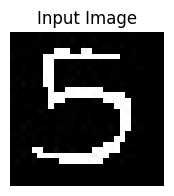

Predicted class: 7


In [13]:
from torchvision import transforms
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')

# Define the image preprocessing steps
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),  # Resize to 28x28 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Set the model to eval mode
model.eval()

# # Loop over 10 images
# for i in range(1, 11):

# Open the image
#img_path = f"/content/gdrive/MyDrive/datasets/mnist_test_sample/img_{i}.jpg"
img_path = "my_5.jpg"
img = Image.open(img_path)

# Preprocess the image
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

# Make prediction
with torch.no_grad():
    output = model(img_tensor)
    print(output)
    predicted_class = output.argmax(1).item()

# Display the image
plt.figure(figsize=(2, 2))  # Set figure size to 2x2 inches
plt.imshow(img, cmap="gray")
plt.title("Input Image")
plt.axis("off")
plt.show()

# Print the prediction
print(f"Predicted class: {predicted_class}")







## Bonus

If you get this far and we're still working, try changing things about your model to make the accuracy higher.

Ideas:
- Change the number of epochs
- Change the batch size
- Change the size of the hidden layer
- Add more hidden layers
